In [1]:
import pandas as pd
import numpy as np

# 전처리 완료 데이터 불러오기
data_a = pd.read_csv("./datasets/data_after/전처리_최종_V3_loglag.csv", encoding="CP949")
data_a = data_a.set_index('기준월')

### 기초통계량 분석

In [ ]:
# # 데이터프레임의 정보
# data_a.info()

In [ ]:
# # 결측치 확인
# data_a.isna().sum()

In [ ]:
# # 결측치 확인
# data_a.isna().sum()

In [ ]:
# # 기초 통계 조회
# data_a.describe()

In [7]:
# # 아주 간단하게 상관관계 분석
# data_a.corr()

### 상관관계 히트맵으로 시각화

c:\Users\subin\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\subin\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


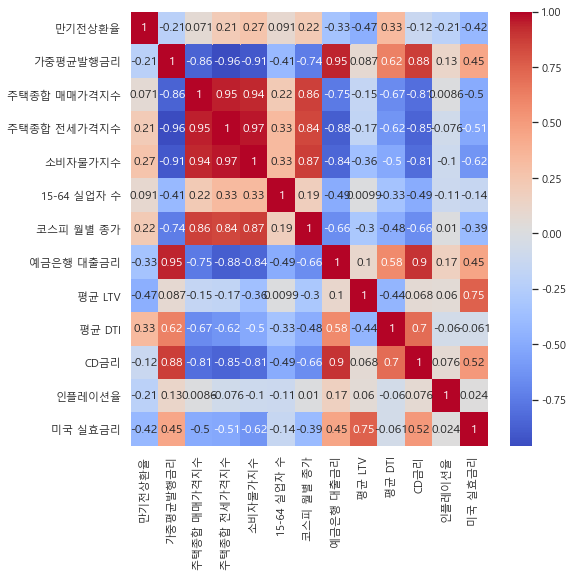

In [2]:
# 히트맵을 위한 라이브러리 호출
import matplotlib.pyplot as plt
import seaborn as sns

# 히트맵 드로잉
sns.set(rc={'figure.figsize':(8,8)}) ## 히트맵 크기 설정
plt.rc('font', family='Malgun Gothic') ## 한글 깨짐 설정
sns.heatmap(data_a.corr(), annot=True, cmap='coolwarm') ## 히트맵 그리기
plt.rcParams['axes.unicode_minus'] = False ## 마이너스 부호 깨지는 걸 방지함
plt.show()

In [3]:
# 모든 컬럼VIF 확인
from test_package import find_vif
find_vif(data_a)

      VIF Factor     features
0   39764.936526      소비자물가지수
1    8546.100893       평균 LTV
2    7353.008523    코스피 월별 종가
3    5235.294113       평균 DTI
4    4861.663748  15-64 실업자 수
5    2483.070369  주택종합 전세가격지수
6    1654.843408  주택종합 매매가격지수
7     869.053549     가중평균발행금리
8     720.877363    예금은행 대출금리
9      78.405715         CD금리
10     19.393834      미국 실효금리
11     12.094371       만기전상환율
12      1.568798       인플레이션율


### Scaling
- Standard : 데이터를 표준정규분포 모양으로 만듬 -> 데이터 특성을 반영 못 하니까 못 씀
- Robuster : 아웃라이어를 없애버림 -> 막판에 만기전상환율이 튀는 걸 살리는 게 맞는 것 같음 -> 못 씀
- Min-Max : 아웃라이어 살리고 데이터 분포 살림 (-> 남는 게 이거 뿐)

In [4]:
# Min - Max Scaler
from sklearn.preprocessing import MinMaxScaler

data_c = data_a.copy().reset_index()
scaler = MinMaxScaler()
mm_temp = data_c.drop(columns=['기준월','만기전상환율'])
colnames = data_c.columns.drop(['기준월','만기전상환율'])

mm_data = scaler.fit_transform(mm_temp)

mm_result = pd.DataFrame(mm_data, columns=colnames)

In [6]:
# # Min-Max 스케일링 잘 됐는지 확인
# mm_result.describe()

### 피처, 타겟 설정

In [5]:
# 최적의 알파값을 찾기 전에 피처랑 타겟 설정
## 주요 요인 별로 나눈 이유 -> 각 상관관계가 너무 높아서
    #### !!추가할 변수들 더 생기면 여기에 추가하기!!
    
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

target = data_a['만기전상환율'] ### 타깃

feature_data = mm_result        ### ALL

## 변수 각각 분석
# feature_data_A = mm_result[['가중평균발행금리', '예금은행 대출금리', 'CD금리']]         ### 금리 요인(CD포함)
feature_data_A = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리']] ### 금리 요인(CD미포함)
feature_data_B = mm_result[['주택종합 매매가격지수', '평균 LTV', '평균 DTI']]           ### 부동산 요인
feature_data_C = mm_result[['15-64 실업자 수', '인플레이션율', '코스피 월별 종가']]     ### 거시경제 요인
##---------------------------------------------------------------------------------------------

## 변수 합쳐서 분석
feature_data2_A = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리']]                                 ### 금리 요인(CD미포함)
feature_data2_B = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리', '주택종합 매매가격지수', '평균 LTV', '평균 DTI']] ### 금리 요인 + 부동산 요인
feature_data2_C = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리', '주택종합 매매가격지수', '평균 LTV', '평균 DTI'
                            , '15-64 실업자 수', '인플레이션율', '코스피 월별 종가']]                                   ### 금리 요인 + 부동산 요인 + 거시경제 요인
##---------------------------------------------------------------------------------------------

## 변수 상관관계 높은거 vs 아닌거
feature_data_S = mm_result[['예금은행 대출금리', '미국 실효금리', '평균 LTV', '평균 DTI']]           ### 알파값 높여도 살아남은 요인
feature_data_W = mm_result[['가중평균발행금리', '주택종합 매매가격지수', '15-64 실업자 수', '인플레이션율', '코스피 월별 종가']]     ### 죽은 요인


In [57]:
# VIF after Min-Max Scaling
## 카테고리끼리 VIF 비교

from test_package import find_vif

datas = [feature_data
        , feature_data_A, feature_data_B, feature_data_C
        , feature_data2_A, feature_data2_B, feature_data2_C
        , feature_data_S, feature_data_W]
num = range(1,len(datas)+1)
### >> for문에 들어가는 변수의 위치(feature_data는 0)도 VIF출력할 때 번호 붙여서 같이 출력(근데 번호는 1부터 시작하고 싶음)
### 요인들 번호 매기고 VIF 출력
for num, data in zip(num, datas):
        # print("번호", num)
        print(f'번호 {num}')
        find_vif(data)
        print(' ')

번호 1
    VIF Factor     features
0   333.161088      소비자물가지수
1   325.060507  주택종합 전세가격지수
2   183.988324  주택종합 매매가격지수
3   140.393226         CD금리
4   108.307462    코스피 월별 종가
5    98.240305    예금은행 대출금리
6    92.952192     가중평균발행금리
7    47.711223       평균 DTI
8    29.260006       평균 LTV
9    18.988968      미국 실효금리
10    9.409641       인플레이션율
11    7.668968  15-64 실업자 수
 
번호 2
   VIF Factor   features
0   24.645098  예금은행 대출금리
1   24.338242   가중평균발행금리
2    1.980578    미국 실효금리
 
번호 3
   VIF Factor     features
0    2.659064       평균 LTV
1    2.375083       평균 DTI
2    2.321795  주택종합 매매가격지수
 
번호 4
   VIF Factor     features
0    7.126936    코스피 월별 종가
1    5.074282       인플레이션율
2    4.078608  15-64 실업자 수
 
번호 5
   VIF Factor   features
0   24.645098  예금은행 대출금리
1   24.338242   가중평균발행금리
2    1.980578    미국 실효금리
 
번호 6
   VIF Factor     features
0   44.573633    예금은행 대출금리
1   43.160018     가중평균발행금리
2   10.718813       평균 LTV
3    9.958828       평균 DTI
4    6.464674  주택종합 매매가격지수
5    5.946803     

In [59]:
# VIF after Min-Max Scaling
## 카테고리끼리 VIF 비교

from test_package import find_vif

datas = [feature_data
        , feature_data_A, feature_data_B, feature_data_C
        , feature_data2_A, feature_data2_B, feature_data2_C
        , feature_data_S, feature_data_W]
# names = feature_data.columns.to_list()

# print(f'전체 변수 요인 : {feature_data.columns.to_list()}')
### >> for문에 들어가는 변수의 위치(feature_data는 0)도 VIF출력할 때 번호 붙여서 같이 출력(근데 번호는 1부터 시작하고 싶음)
### 요인들 번호 매기고 VIF 출력
for i in datas:
    print(f'요인 : {i.columns.to_list()}')
    find_vif(i)
    print(' ')

요인 : ['가중평균발행금리', '주택종합 매매가격지수', '주택종합 전세가격지수', '소비자물가지수', '15-64 실업자 수', '코스피 월별 종가', '예금은행 대출금리', '평균 LTV', '평균 DTI', 'CD금리', '인플레이션율', '미국 실효금리']
    VIF Factor     features
0   333.161088      소비자물가지수
1   325.060507  주택종합 전세가격지수
2   183.988324  주택종합 매매가격지수
3   140.393226         CD금리
4   108.307462    코스피 월별 종가
5    98.240305    예금은행 대출금리
6    92.952192     가중평균발행금리
7    47.711223       평균 DTI
8    29.260006       평균 LTV
9    18.988968      미국 실효금리
10    9.409641       인플레이션율
11    7.668968  15-64 실업자 수
 
요인 : ['가중평균발행금리', '예금은행 대출금리', '미국 실효금리']
   VIF Factor   features
0   24.645098  예금은행 대출금리
1   24.338242   가중평균발행금리
2    1.980578    미국 실효금리
 
요인 : ['주택종합 매매가격지수', '평균 LTV', '평균 DTI']
   VIF Factor     features
0    2.659064       평균 LTV
1    2.375083       평균 DTI
2    2.321795  주택종합 매매가격지수
 
요인 : ['15-64 실업자 수', '인플레이션율', '코스피 월별 종가']
   VIF Factor     features
0    7.126936    코스피 월별 종가
1    5.074282       인플레이션율
2    4.078608  15-64 실업자 수
 
요인 : ['가중평균발행금리', '예금은행 대출금리', '미국 실

### 최적의 알파값 & 요인 별 RMSE 스코어 계산

############################# 여기도 
    print(f'요인 : {i.columns.to_list()}')
    써서 컬럼명 가져오기

In [22]:
from test_package import alpha_master, find_best_alpha

### 75% 수준의 데이터만 가지고 돌렸을 때

datas = [feature_data
        , feature_data_A, feature_data_B, feature_data_C
        , feature_data2_A, feature_data2_B, feature_data2_C
        , feature_data_S, feature_data_W]

# names = ['feature_all'
#         , 'feature_data_A', 'feature_data_B', 'feature_data_C'
#         , 'feature_data2_A', 'feature_data2_B', 'feature_data2_C'
#         , 'feature_data_S', 'feature_data_W']

types = ['ridge', 'lasso', 'elastic']

num = range(1,len(datas)+1)

for num, data in zip(num, datas):
    datas[num-1].index.name = names[num-1]
    print(datas[num-1].index.name)
    for i in range(0, len(types)):
        alpha_master(types[i], data[:161], target[:161])

### find_best_alpha + score_checker
### alpha_master('elastic', feature_data, target)

feature_all
Type : ridge | {'alpha': 1.0} | MSE : 0.3364498473852631 | RMSE: 0.5800429702920837
Alpha : 1.0
ridge Negative MSE score : [0.681 0.178 0.094 1.171 4.076]
ridge RMSE scores : [0.825 0.422 0.306 1.082 2.019]
ridge AVG RMSE : 0.931

Type : lasso | {'alpha': 0.01} | MSE : 0.0976332460768398 | RMSE: 0.3124631915551651
Alpha : 0.01
lasso Negative MSE score : [0.736 0.051 0.071 1.077 3.373]
lasso RMSE scores : [0.858 0.226 0.266 1.038 1.837]
lasso AVG RMSE : 0.845

Type : elastic | {'alpha': 0.01} | MSE : 0.08240894587605974 | RMSE: 0.2870695836832243
Alpha : 0.01
elastic Negative MSE score : [0.561 0.097 0.078 1.159 3.694]
elastic RMSE scores : [0.749 0.311 0.279 1.077 1.922]
elastic AVG RMSE : 0.867

feature_data_A
Type : ridge | {'alpha': 1.0} | MSE : 0.3398030304538879 | RMSE: 0.5829262650231913
Alpha : 1.0
ridge Negative MSE score : [0.665 0.155 0.168 1.431 3.144]
ridge RMSE scores : [0.816 0.394 0.41  1.196 1.773]
ridge AVG RMSE : 0.918

Type : lasso | {'alpha': 0.02} | MSE

##### 해야 할 것
> 코드 중복된거 -> 함수 다시 만들기  
들어가는 피쳐들 개별적 쓰지 말고 리스트 정리   
그래프 이쁘게 하자

### 예측

In [23]:
# Train Set : Test Set = 75% : 25%
# Test SET 20%일 경우 코로나 시국 데이터가 좀 더 반영됨

## 변수 각각 요인 데이터
# feature_data_A : 금리 요인(CD O)
# feature_data_AA : 금리 요인(미국 O)
# feature_data_B : 부동산 요인
# feature_data_C : 거시경제 요인

## 변수 합한 요인 데이터
## feature_data2_A : 금리 요인
## feature_data2_B : 금리 + 부동산 요인
## feature_data2_C : 금리 + 부동산 + 거시경제 요인

###########################################
# 가장 잘 나온 모델로 예측이라는 걸 해봅시다 #
###########################################

## 단일변수
xa_train, xa_test, ya_train, ya_test = train_test_split(feature_data_A, target, test_size=0.25, random_state=25)
xa_model = Lasso(alpha=0.02, random_state=25)
xa_model.fit(xa_train, ya_train)
xa_pred = xa_model.predict(xa_test)

xb_train, xb_test, yb_train, yb_test = train_test_split(feature_data_B, target, test_size=0.25, random_state=25)
xb_model = Lasso(alpha=0.04, random_state=25)
xb_model.fit(xb_train, yb_train)
xb_pred = xb_model.predict(xb_test)

xc_train, xc_test, yc_train, yc_test = train_test_split(feature_data_C, target, test_size=0.25, random_state=25)
xc_model = Ridge(alpha=0.04, random_state=25)
xc_model.fit(xc_train, yc_train)
xc_pred = xc_model.predict(xc_test)

xd_train, xd_test, yd_train, yd_test = train_test_split(feature_data, target, test_size=0.25, random_state=25)
xd_model = Lasso(alpha=0.01, random_state=25)
xd_model.fit(xd_train, yd_train)
xd_pred = xd_model.predict(xd_test)
###------------------------------------------------------------------------------------------

## 합친변수
xaa_train, xaa_test, yaa_train, yaa_test = train_test_split(feature_data2_A, target, test_size=0.25, random_state=25)
xaa_model = Lasso(alpha=0.02, random_state=25)
xaa_model.fit(xaa_train, yaa_train)
xaa_pred = xaa_model.predict(xaa_test)

xbb_train, xbb_test, ybb_train, ybb_test = train_test_split(feature_data2_B, target, test_size=0.25, random_state=25)
xbb_model = Lasso(alpha=0.04, random_state=25)
xbb_model.fit(xbb_train, ybb_train)
xbb_pred = xbb_model.predict(xbb_test)

xcc_train, xcc_test, ycc_train, ycc_test = train_test_split(feature_data2_C, target, test_size=0.25, random_state=25)
xcc_model = Ridge(alpha=0.04, random_state=25)
xcc_model.fit(xcc_train, ycc_train)
xcc_pred = xcc_model.predict(xcc_test)

xdd_train, xdd_test, ydd_train, ydd_test = train_test_split(feature_data, target, test_size=0.25, random_state=25)
xdd_model = Lasso(alpha=0.01, random_state=25)
xdd_model.fit(xdd_train, ydd_train)
xdd_pred = xdd_model.predict(xdd_test)
###------------------------------------------------------------------------------------------

## 강한, 약한 변수
xas_train, xas_test, yas_train, yas_test = train_test_split(feature_data_S, target, test_size=0.25, random_state=25)
xas_model = Lasso(alpha=0.02, random_state=25)
xas_model.fit(xas_train, yas_train)
xas_pred = xas_model.predict(xas_test)

xbw_train, xbw_test, ybw_train, ybw_test = train_test_split(feature_data_W, target, test_size=0.25, random_state=25)
xbw_model = Lasso(alpha=0.04, random_state=25)
xbw_model.fit(xbw_train, ybw_train)
xbw_pred = xbw_model.predict(xbw_test)

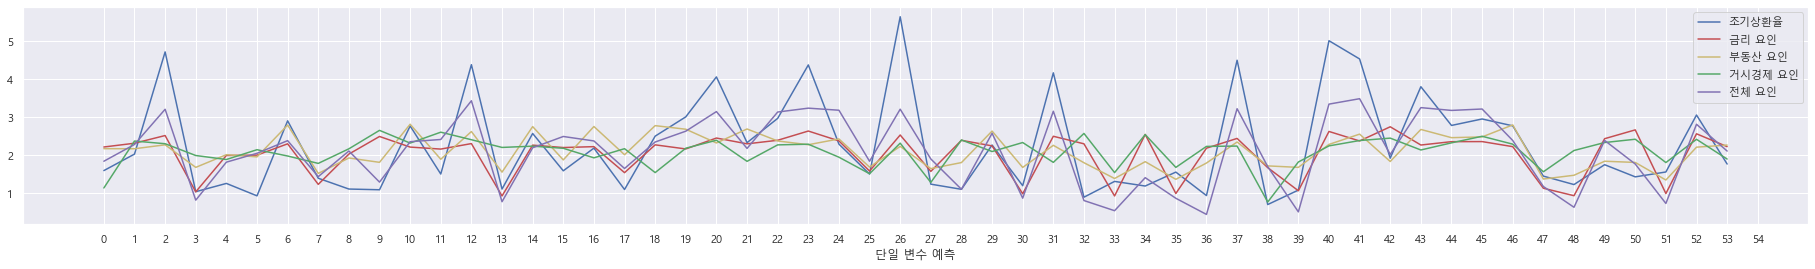

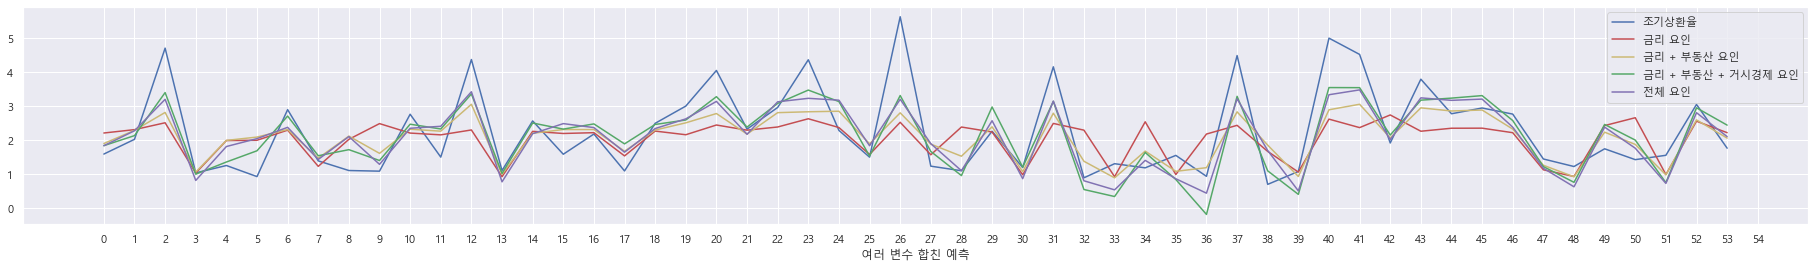

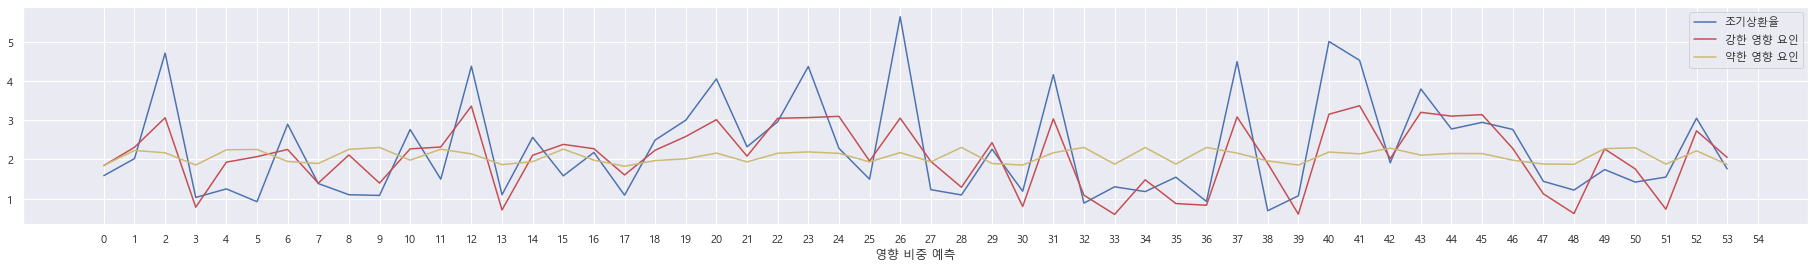

In [49]:
# 단일변수 한번에 시각화
fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("단일 변수 예측")
plt.xticks(range(55), range(55))
plt.plot(yd_test, label="조기상환율")
plt.plot(xa_pred, label="금리 요인", c='r')
plt.plot(xb_pred, label="부동산 요인", c='y')
plt.plot(xc_pred, label="거시경제 요인", c='g')
plt.plot(xd_pred, label="전체 요인", c='m')

plt.legend(loc='upper right')
plt.show()

# 합친변수 한번에 시각화
fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("여러 변수 합친 예측")
plt.xticks(range(55), range(55))
plt.plot(ydd_test, label="조기상환율")
plt.plot(xaa_pred, label="금리 요인", c='r')
plt.plot(xbb_pred, label="금리 + 부동산 요인", c='y')
plt.plot(xcc_pred, label="금리 + 부동산 + 거시경제 요인", c='g')
plt.plot(xdd_pred, label="전체 요인", c='m')

plt.legend(loc='upper right')
plt.show()

## 강한, 약한 변수
fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("영향 비중 예측")
plt.xticks(range(55), range(55))
plt.plot(ydd_test, label="조기상환율")
plt.plot(xas_pred, label="강한 영향 요인", c='r')
plt.plot(xbw_pred, label="약한 영향 요인", c='y')


plt.legend(loc='upper right')
plt.show()

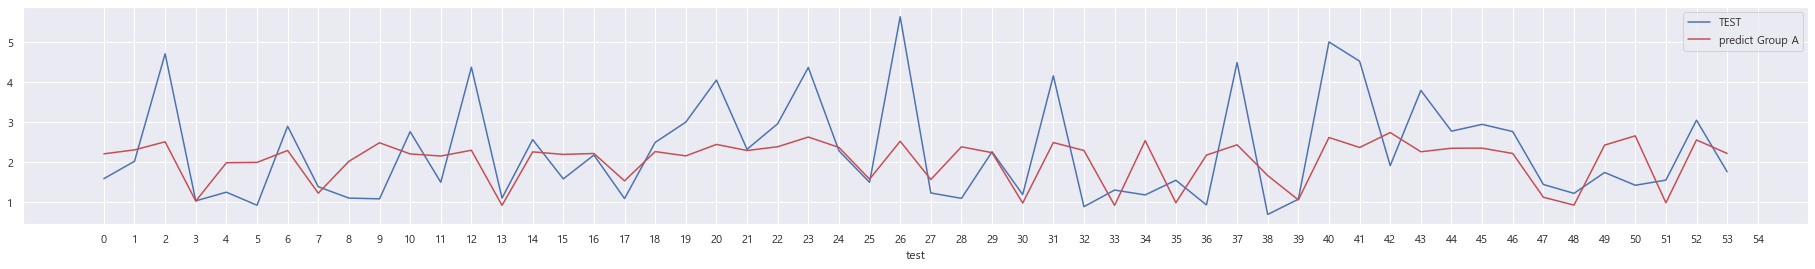

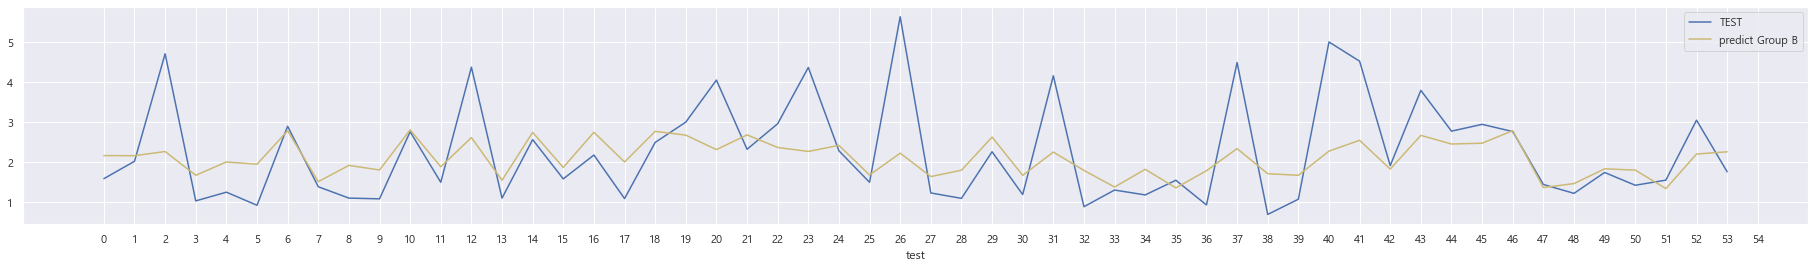

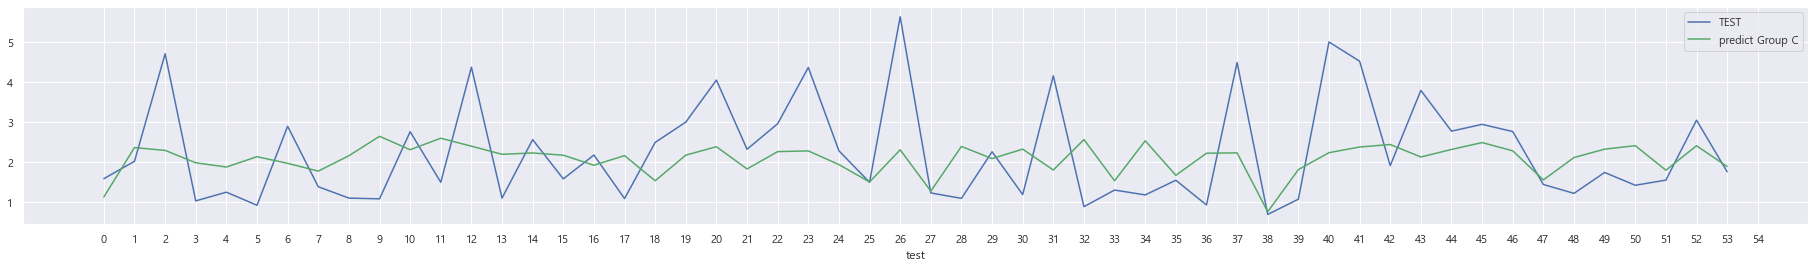

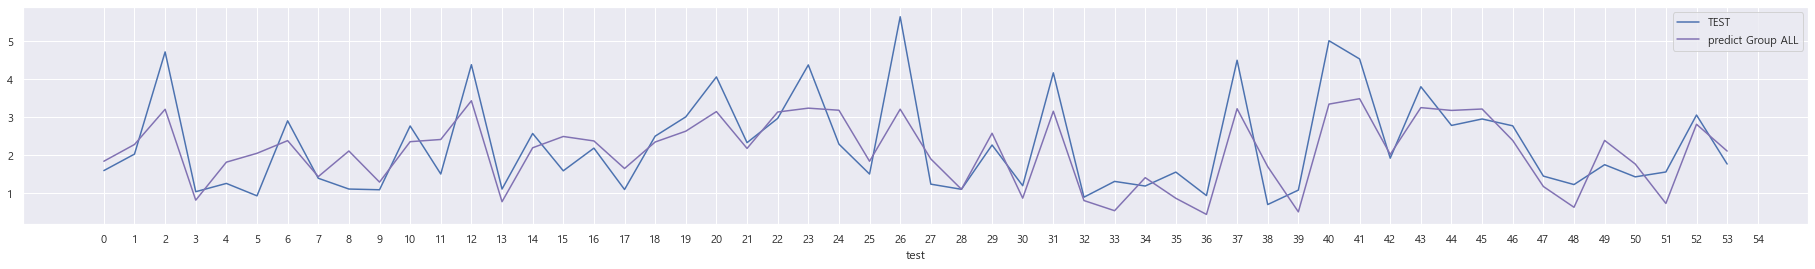

In [25]:
# 단일변수 각각 시각화
fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(ya_test, label="TEST")
plt.plot(xa_pred, label="predict Group A", c='r')
plt.legend(loc='upper right')
plt.show()

fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(yb_test, label="TEST")
plt.plot(xb_pred, label="predict Group B", c='y')
plt.legend(loc='upper right')
plt.show()

fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(yc_test, label="TEST")
plt.plot(xc_pred, label="predict Group C", c='g')
plt.legend(loc='upper right')
plt.show()

fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(yd_test, label="TEST")
plt.plot(xd_pred, label="predict Group ALL", c='m')
plt.legend(loc='upper right')
plt.show()

In [50]:
# 그래서 RMSE가 얼마나 나왔을까

from sklearn.metrics import mean_squared_error, accuracy_score

mse_a = mean_squared_error(ya_test, xa_pred)
rmse_a = mse_a ** 0.5

mse_b = mean_squared_error(yb_test, xb_pred)
rmse_b = mse_b ** 0.5

mse_c = mean_squared_error(yc_test, xc_pred)
rmse_c = mse_c ** 0.5

mse_all = mean_squared_error(yd_test, xd_pred)
rmse_all = mse_all ** 0.5

print(f'금리 요인 RMSE : {rmse_a:.3f}')
print(f'부동산 요인 RMSE : {rmse_b:.3f}')
print(f'거시경제 요인 RMSE : {rmse_c:.3f}')
print(f'전체 요인 RMSE : {rmse_all:.3f}')

금리 요인 RMSE : 1.100
부동산 요인 RMSE : 1.064
거시경제 요인 RMSE : 1.230
전체 요인 RMSE : 0.748


In [51]:
mse_aa = mean_squared_error(yaa_test, xaa_pred)
rmse_aa = mse_aa ** 0.5

mse_bb = mean_squared_error(ybb_test, xbb_pred)
rmse_bb = mse_bb ** 0.5

mse_cc = mean_squared_error(ycc_test, xcc_pred)
rmse_cc = mse_cc ** 0.5

mse_all2 = mean_squared_error(ydd_test, xdd_pred)
rmse_all2 = mse_all2 ** 0.5

print(f'금리 요인 RMSE : {rmse_aa:.3f}')
print(f'금리 + 부동산 요인 RMSE : {rmse_bb:.3f}')
print(f'금리 + 부동산 + 거시경제 요인 RMSE : {rmse_cc:.3f}')
print(f'전체 요인 RMSE : {rmse_all2:.3f}')

금리 요인 RMSE : 1.100
금리 + 부동산 요인 RMSE : 0.861
금리 + 부동산 + 거시경제 요인 RMSE : 0.704
전체 요인 RMSE : 0.748


1. 각각 변수 한것 보다 합한 변수가 예측률이 좋고  
2.  모든 변수 사용한 것 보다 금리, 부동산, 거시경제 요인 변수들만 사용한게 예측률이 높음

----------------------------------------------------------------------------
----------------------------------------------------------------------------
##### 생각해볼 것
> 1. 상대적으로 RMSE가 좋지 않다고 판된되는 그룹들을 대상으로 앙상블 수행  
> 2. 금리 요인을 시작으로 하나하나 추가하면서 다시 분석해보기 (+ 다른 feature 찾기)  
> 3. 만기 전 상환율을 ARIMA로 예측이 가능한... 거 맞아?  


- 위에 있는 건 아까 best alpha 구했을 때하고 비교하면 좋을 거 같고

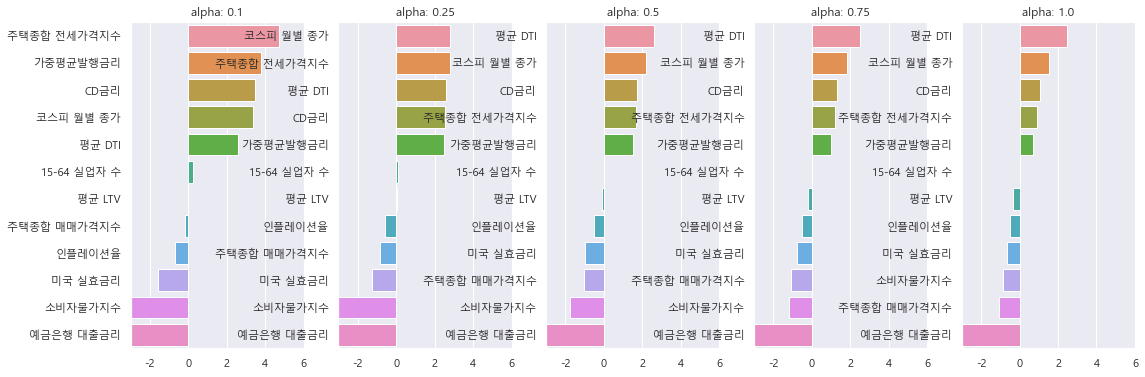

             alpha: 0.1  alpha: 0.25  alpha: 0.5  alpha: 0.75  alpha: 1.0
주택종합 전세가격지수    4.688452     2.790381    1.665693     1.191954    0.934006
가중평균발행금리       3.758139     2.490772    1.515007     1.002057    0.683126
CD금리           3.491139     2.544725    1.735589     1.314981    1.061980
코스피 월별 종가      3.356989     2.817481    2.210733     1.823840    1.554708
평균 DTI         2.598278     2.592724    2.581675     2.531829    2.465499
15-64 실업자 수    0.231307     0.097342    0.028117     0.009128    0.005594
평균 LTV        -0.037068     0.040882   -0.087369    -0.217929   -0.320043
주택종합 매매가격지수   -0.192636    -0.837339   -1.056394    -1.073644   -1.047651
인플레이션율        -0.668520    -0.571711   -0.517492    -0.500423   -0.495000
미국 실효금리       -1.556099    -1.277722   -0.959286    -0.777428   -0.667120
소비자물가지수       -5.480118    -3.125184   -1.737865    -1.157646   -0.840971
예금은행 대출금리     -7.839390    -6.255333   -4.916375    -4.155196   -3.646349


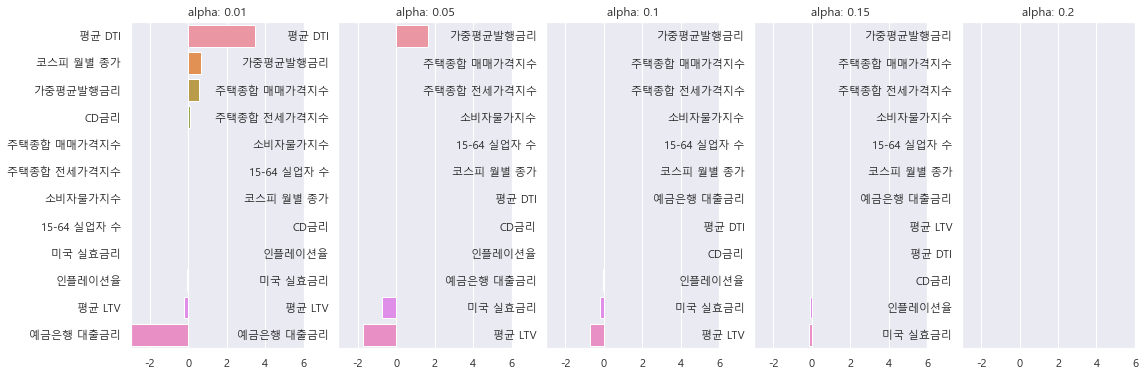

             alpha: 0.01  alpha: 0.05  alpha: 0.1  alpha: 0.15  alpha: 0.2
평균 DTI          3.448540     1.638932    0.000000     0.000000         0.0
코스피 월별 종가       0.661308     0.000000    0.000000     0.000000         0.0
가중평균발행금리        0.572010    -0.000000   -0.000000    -0.000000        -0.0
CD금리            0.114020    -0.000000   -0.000000    -0.000000        -0.0
주택종합 매매가격지수    -0.000000    -0.000000    0.000000     0.000000         0.0
주택종합 전세가격지수     0.000000     0.000000    0.000000     0.000000         0.0
소비자물가지수        -0.000000     0.000000    0.000000     0.000000         0.0
15-64 실업자 수    -0.000000     0.000000    0.000000     0.000000         0.0
미국 실효금리        -0.000000    -0.000000   -0.224610    -0.090081        -0.0
인플레이션율         -0.057467    -0.000000   -0.000000    -0.000000        -0.0
평균 LTV         -0.247702    -0.722224   -0.697494    -0.154352        -0.0
예금은행 대출금리      -3.749573    -1.721819   -0.044676    -0.000000        -0.0


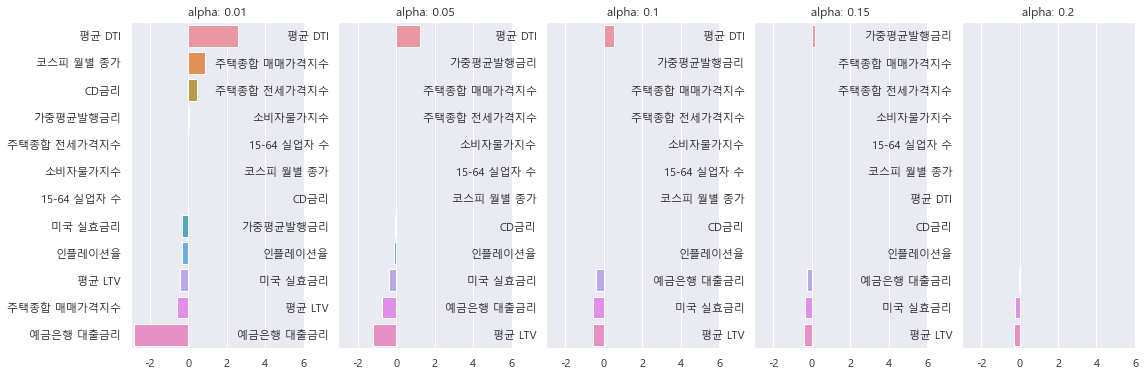

             alpha: 0.01  alpha: 0.05  alpha: 0.1  alpha: 0.15  alpha: 0.2
평균 DTI          2.574141     1.218307    0.531442     0.195661    0.000000
코스피 월별 종가       0.848891     0.000000    0.000000     0.000000    0.000000
CD금리            0.463073     0.000000   -0.000000    -0.000000   -0.000000
가중평균발행금리        0.028216    -0.047976   -0.000000    -0.000000   -0.000000
주택종합 전세가격지수     0.000000     0.000000    0.000000     0.000000    0.000000
소비자물가지수        -0.000000     0.000000    0.000000     0.000000    0.000000
15-64 실업자 수    -0.000000     0.000000    0.000000     0.000000    0.000000
미국 실효금리        -0.317467    -0.349849   -0.389577    -0.327146   -0.245366
인플레이션율         -0.334132    -0.125762   -0.000000    -0.000000   -0.000000
평균 LTV         -0.442539    -0.727672   -0.573189    -0.422991   -0.292807
주택종합 매매가격지수    -0.581067    -0.000000   -0.000000     0.000000    0.000000
예금은행 대출금리      -2.839756    -1.179818   -0.558286    -0.230504   -0.032564


In [54]:
# 문득 이런 생각
# Best alpha로 RMSE를 찾긴 찾았는데
# 그래프 뭐가 대충 일치하는 게 보였어. 근데 전체 요인이 Best야
# 알파를 좀 더 변화시켜보자. 뭐가 큰 영향을 준 걸까.
# 이거도 요인 별로 하나하나 돌려봅시다

from test_package import check_coeff

# 구하고 싶은 알파는 따로 입력하고
alphas1 = [0.01, 0.05, 0.1, 0.15, 0.2]
alphas2 = [0.1, 0.25, 0.5, 0.75, 1.0]
alphas3 = [0.01, 0.05, 0.1, 0.15, 0.2]
# check_coeff(type, data, target, alpha)
# type = 'ridge', 'lasso', 'elastic'
check_coeff('ridge', feature_data, target, alphas2)
check_coeff('lasso', feature_data, target, alphas1)
check_coeff('elastic', feature_data, target, alphas1)

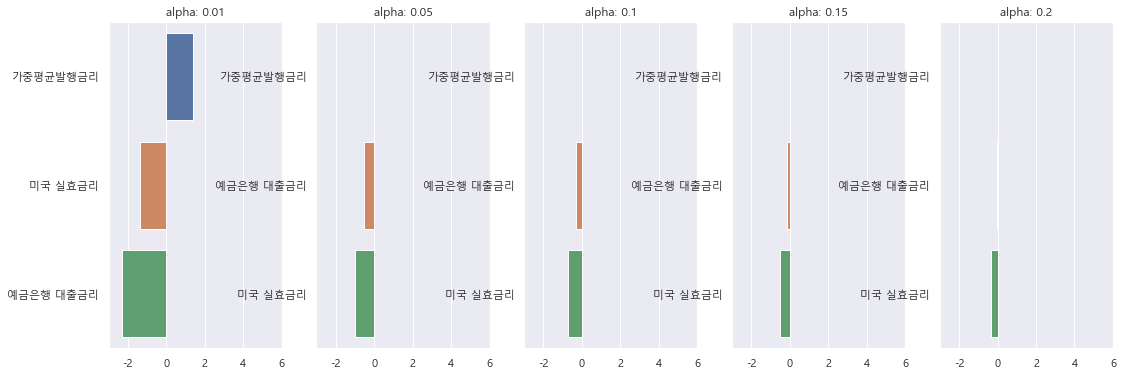

           alpha: 0.01  alpha: 0.05  alpha: 0.1  alpha: 0.15  alpha: 0.2
가중평균발행금리      1.382691     0.000000   -0.000000    -0.000000   -0.000000
미국 실효금리      -1.371280    -0.995368   -0.717645    -0.507067   -0.342208
예금은행 대출금리    -2.291472    -0.546432   -0.320829    -0.153593   -0.024301


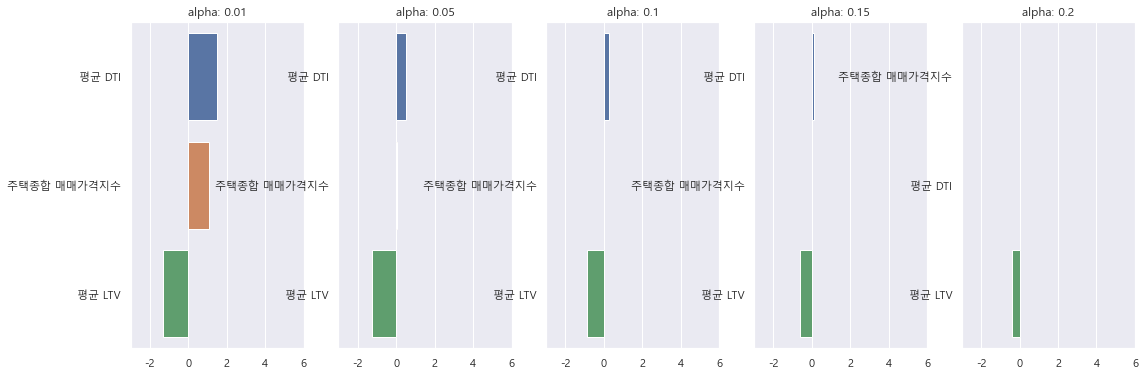

             alpha: 0.01  alpha: 0.05  alpha: 0.1  alpha: 0.15  alpha: 0.2
평균 DTI          1.487378     0.517204    0.272063     0.103193    0.000000
주택종합 매매가격지수     1.070551     0.044402    0.000000     0.000000    0.000000
평균 LTV         -1.335536    -1.258574   -0.870820    -0.593851   -0.384502


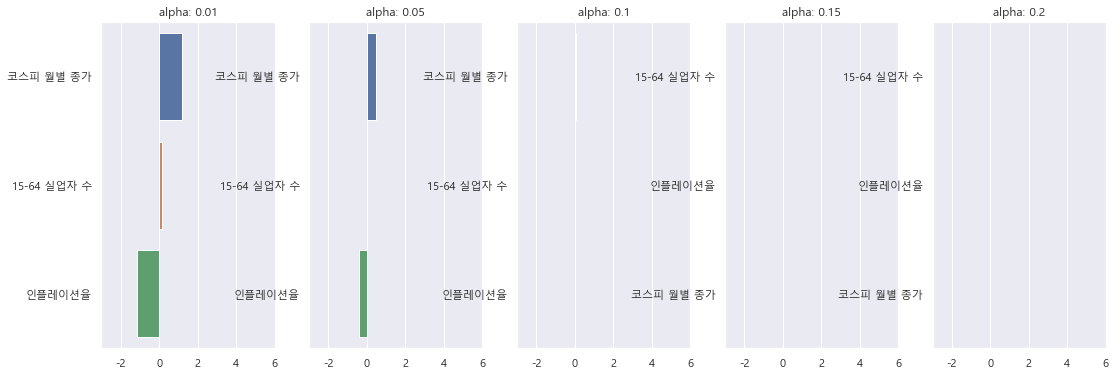

             alpha: 0.01  alpha: 0.05  alpha: 0.1  alpha: 0.15  alpha: 0.2
코스피 월별 종가       1.179016     0.485425    0.055305          0.0         0.0
15-64 실업자 수     0.123590     0.000000    0.000000          0.0         0.0
인플레이션율         -1.141797    -0.409585   -0.000000         -0.0        -0.0


In [16]:
# 구하고 싶은 알파는 따로 입력
alphas = [0.01, 0.05, 0.1, 0.15, 0.2]

# check_coeff(type, data, target, alpha)
# type = 'ridge', 'lasso', 'elastic'
check_coeff('elastic', feature_data_A, target, alphas)

# 구하고 싶은 알파는 따로 입력하고
alphas = [0.01, 0.05, 0.1, 0.15, 0.2]

# check_coeff(type, data, target, alpha)
# type = 'ridge', 'lasso', 'elastic'
check_coeff('elastic', feature_data_B, target, alphas)

# 구하고 싶은 알파는 따로 입력하고
alphas = [0.01, 0.05, 0.1, 0.15, 0.2]

# check_coeff(type, data, target, alpha)
# type = 'ridge', 'lasso', 'elastic'
check_coeff('elastic', feature_data_C, target, alphas)

In [29]:
from test_package import score_checker
feature_data_best = feature_data[['평균 LTV', '평균 DTI', '예금은행 대출금리', '미국 실효금리']]

find_best_alpha('elastic', feature_data_best[:161], target[:161])
score_checker('elastic', feature_data_best[:161], target[:161], 0.01)

Type : elastic | {'alpha': 0.01} | MSE : 0.06407534591350302 | RMSE: 0.25313108444737287
Alpha : 0.01
elastic Negative MSE score : [0.6   0.098 0.092 1.2   2.689]
elastic RMSE scores : [0.775 0.313 0.304 1.096 1.64 ]
elastic AVG RMSE : 0.825



In [30]:
from test_package import score_checker


find_best_alpha('elastic', feature_data_best[:161], target[:161])
score_checker('elastic', feature_data_best[:161], target[:161], 0.01)

Type : elastic | {'alpha': 0.01} | MSE : 0.06407534591350302 | RMSE: 0.25313108444737287
Alpha : 0.01
elastic Negative MSE score : [0.6   0.098 0.092 1.2   2.689]
elastic RMSE scores : [0.775 0.313 0.304 1.096 1.64 ]
elastic AVG RMSE : 0.825



In [31]:
# Best Feature Training
xe_train, xe_test, ye_train, ye_test = train_test_split(feature_data_best, target, test_size=0.25, random_state=25)
xe_model = ElasticNet(alpha=0.01, random_state=25)
xe_model.fit(xe_train, ye_train)
xe_pred = xe_model.predict(xe_test)

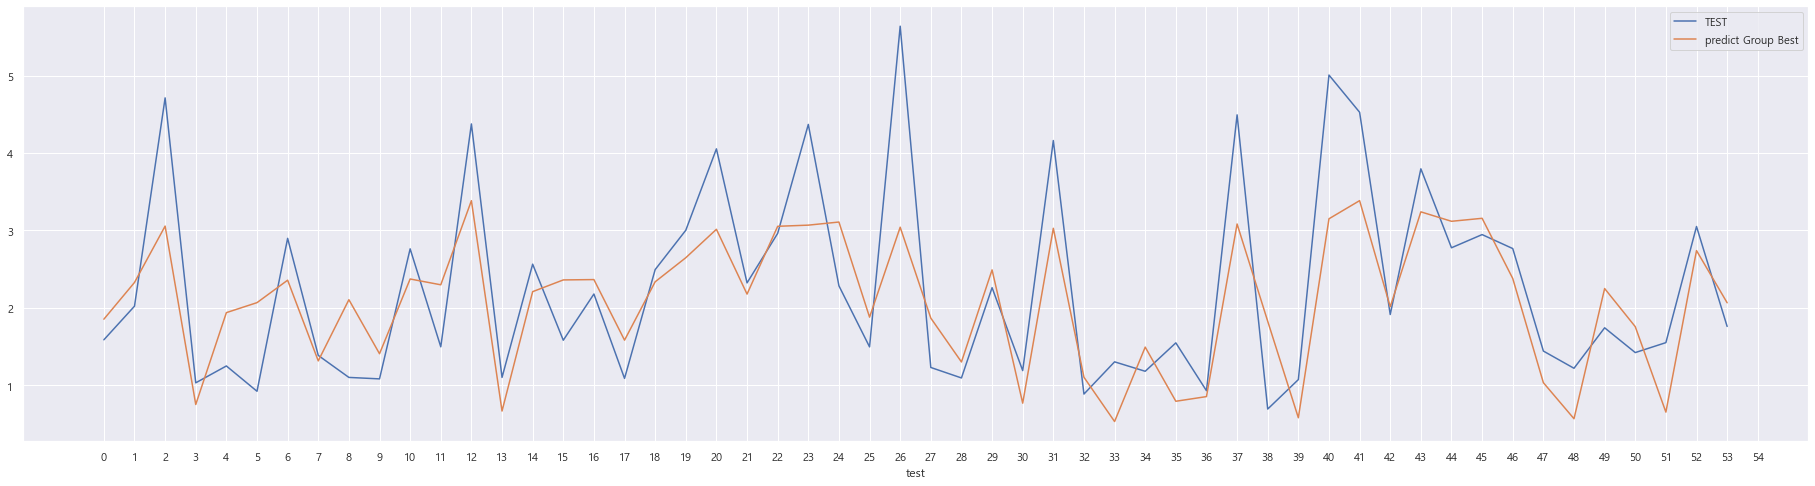

In [32]:
fig, axs = plt.subplots(1,1, figsize=(32,8))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(ye_test, label="TEST")
plt.plot(xe_pred, label="predict Group Best")
plt.legend(loc='upper right')
plt.show()

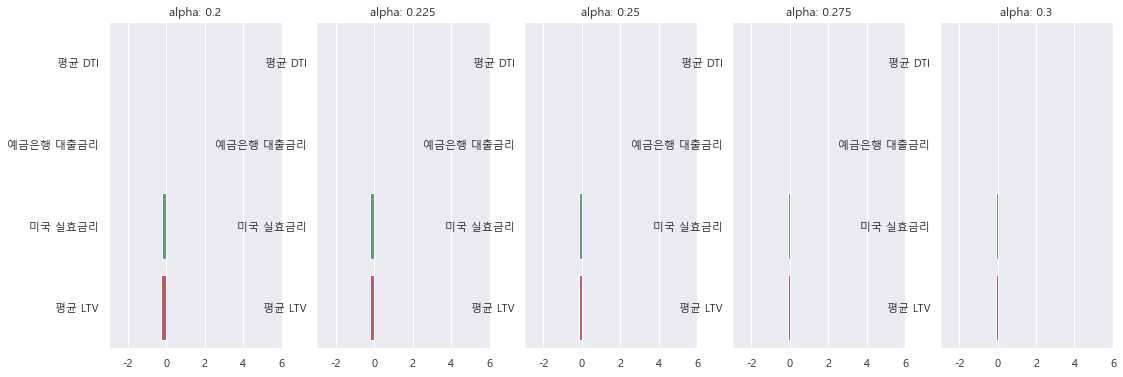

           alpha: 0.2  alpha: 0.225  alpha: 0.25  alpha: 0.275  alpha: 0.3
평균 DTI       0.000000      0.000000     0.000000      0.000000    0.000000
예금은행 대출금리   -0.032567     -0.000000    -0.000000     -0.000000   -0.000000
미국 실효금리     -0.245365     -0.198453    -0.148830     -0.102828   -0.060134
평균 LTV      -0.292810     -0.224281    -0.163905     -0.109521   -0.060220


In [33]:
alphas = [0.2, 0.225, 0.25, 0.275, 0.3]
check_coeff('elastic', feature_data_best, target, alphas)

In [34]:
feature_data_others = feature_data[['가중평균발행금리', '주택종합 매매가격지수', '소비자물가지수', '15-64 실업자 수', '코스피 월별 종가', '인플레이션율']]
feature_data_others

,가중평균발행금리,주택종합 매매가격지수,소비자물가지수,15-64 실업자 수,코스피 월별 종가,인플레이션율
feature_data_W,,,,,,
0,0.922279,0.023902,0.000000,0.270948,0.044228,0.702174
1,0.860130,0.021056,0.015285,0.411797,0.000000,0.834290
2,0.807542,0.016809,0.036912,0.377595,0.059141,0.385088
3,0.771687,0.014553,0.036912,0.247920,0.084785,0.385088
4,0.741210,0.011992,0.036912,0.286896,0.084586,0.073353
...,...,...,...,...,...,...
209,0.011105,0.984391,0.932341,0.238626,0.857809,0.686548
210,0.010817,0.988598,0.946876,0.284627,0.866718,0.758501
211,0.005781,0.990610,0.964867,0.280079,0.881002,0.770460


In [35]:
find_best_alpha('elastic', feature_data_others[:161], target[:161])
score_checker('elastic', feature_data_others[:161], target[:161], 0.01)

Type : elastic | {'alpha': 0.01} | MSE : 0.6449465069873049 | RMSE: 0.8030856162248861
Alpha : 0.01
elastic Negative MSE score : [0.489 0.418 0.155 1.53  3.566]
elastic RMSE scores : [0.7   0.647 0.393 1.237 1.888]
elastic AVG RMSE : 0.973



In [36]:
# Other Feature Training
xf_train, xf_test, yf_train, yf_test = train_test_split(feature_data_others, target, test_size=0.25, random_state=25)
xf_model = ElasticNet(alpha=0.01, random_state=25)
xf_model.fit(xf_train, yf_train)
xf_pred = xf_model.predict(xf_test)

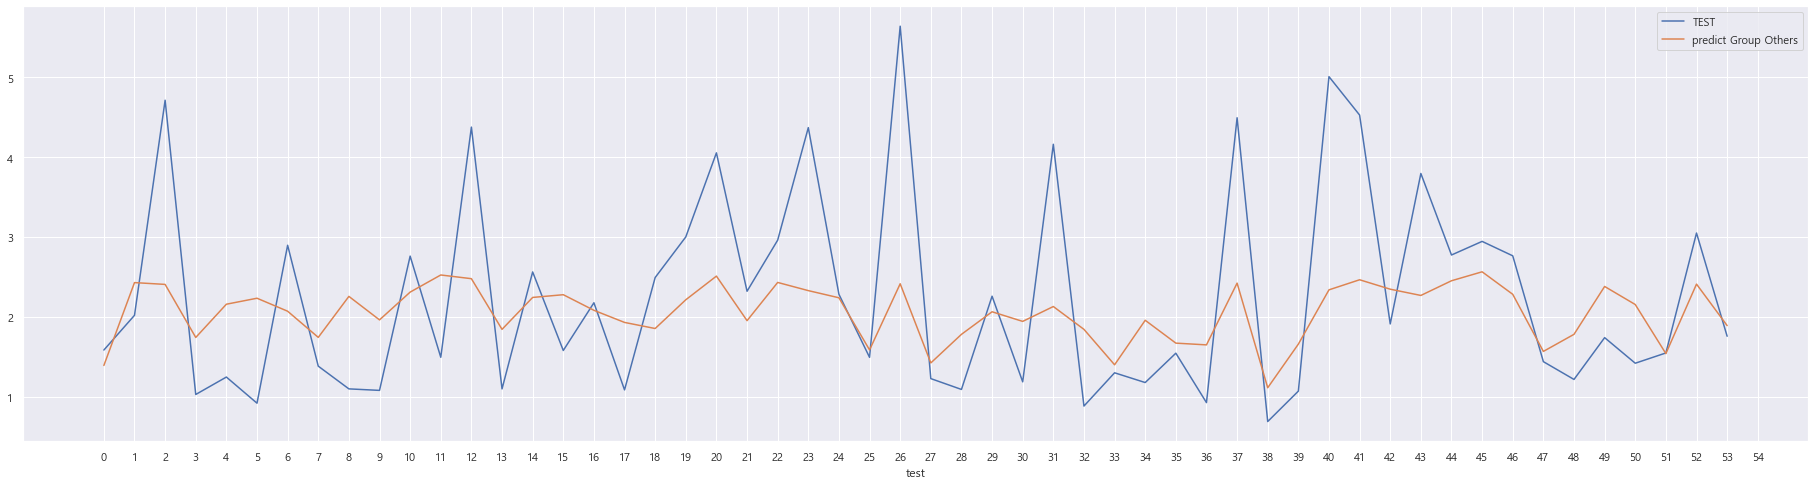

In [37]:
fig, axs = plt.subplots(1,1, figsize=(32,8))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(yf_test, label="TEST")
plt.plot(xf_pred, label="predict Group Others")
plt.legend(loc='upper right')
plt.show()

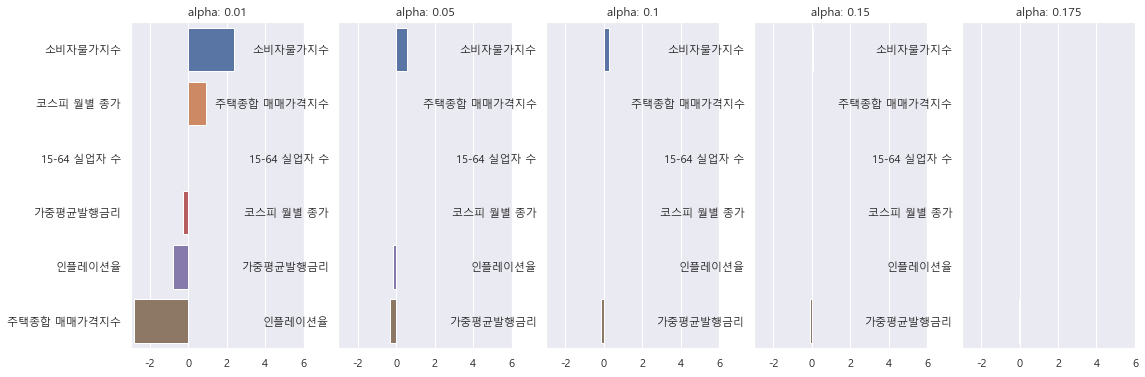

             alpha: 0.01  alpha: 0.05  alpha: 0.1  alpha: 0.15  alpha: 0.175
소비자물가지수         2.376386     0.545138    0.243707     0.072509      0.008035
코스피 월별 종가       0.898980     0.000000    0.000000     0.000000      0.000000
15-64 실업자 수    -0.033450     0.000000    0.000000     0.000000      0.000000
가중평균발행금리       -0.259363    -0.150540   -0.142154    -0.066327     -0.026899
인플레이션율         -0.771857    -0.340059   -0.000000    -0.000000     -0.000000
주택종합 매매가격지수    -2.825685    -0.000000   -0.000000     0.000000      0.000000


In [38]:
alphas = [0.01, 0.05, 0.1, 0.15, 0.175]
check_coeff('elastic', feature_data_others, target, alphas)

In [39]:
feature_data_real_best = feature_data[['평균 LTV', '평균 DTI', '예금은행 대출금리', '미국 실효금리', '소비자물가지수', '가중평균발행금리']]
feature_data_real_best

,평균 LTV,평균 DTI,예금은행 대출금리,미국 실효금리,소비자물가지수,가중평균발행금리
feature_data_W,,,,,,
0,0.779071,0.000000,0.796034,0.188100,0.000000,0.922279
1,0.738665,0.404489,0.787312,0.232246,0.015285,0.860130
2,0.717274,0.606252,0.768107,0.264875,0.036912,0.807542
3,0.732961,0.745031,0.742334,0.299424,0.036912,0.771687
4,0.752134,0.796137,0.733051,0.328215,0.036912,0.741210
...,...,...,...,...,...,...
209,0.659152,0.149045,0.413075,0.005758,0.932341,0.011105
210,0.656930,0.153740,0.419800,0.005758,0.946876,0.010817
211,0.657576,0.149973,0.410822,0.028791,0.964867,0.005781


In [40]:
find_best_alpha('elastic', feature_data_real_best[:161], target[:161])
score_checker('elastic', feature_data_real_best[:161], target[:161], 0.01)

Type : elastic | {'alpha': 0.01} | MSE : 0.14887345391145043 | RMSE: 0.38584122889013617
Alpha : 0.01
elastic Negative MSE score : [0.601 0.118 0.105 1.178 3.354]
elastic RMSE scores : [0.775 0.344 0.323 1.085 1.831]
elastic AVG RMSE : 0.872



In [41]:
# real best Feature Training
xg_train, xg_test, yg_train, yg_test = train_test_split(feature_data_real_best, target, test_size=0.25, random_state=25)
xg_model = ElasticNet(alpha=0.01, random_state=25)
xg_model.fit(xg_train, yg_train)
xg_pred = xg_model.predict(xg_test)

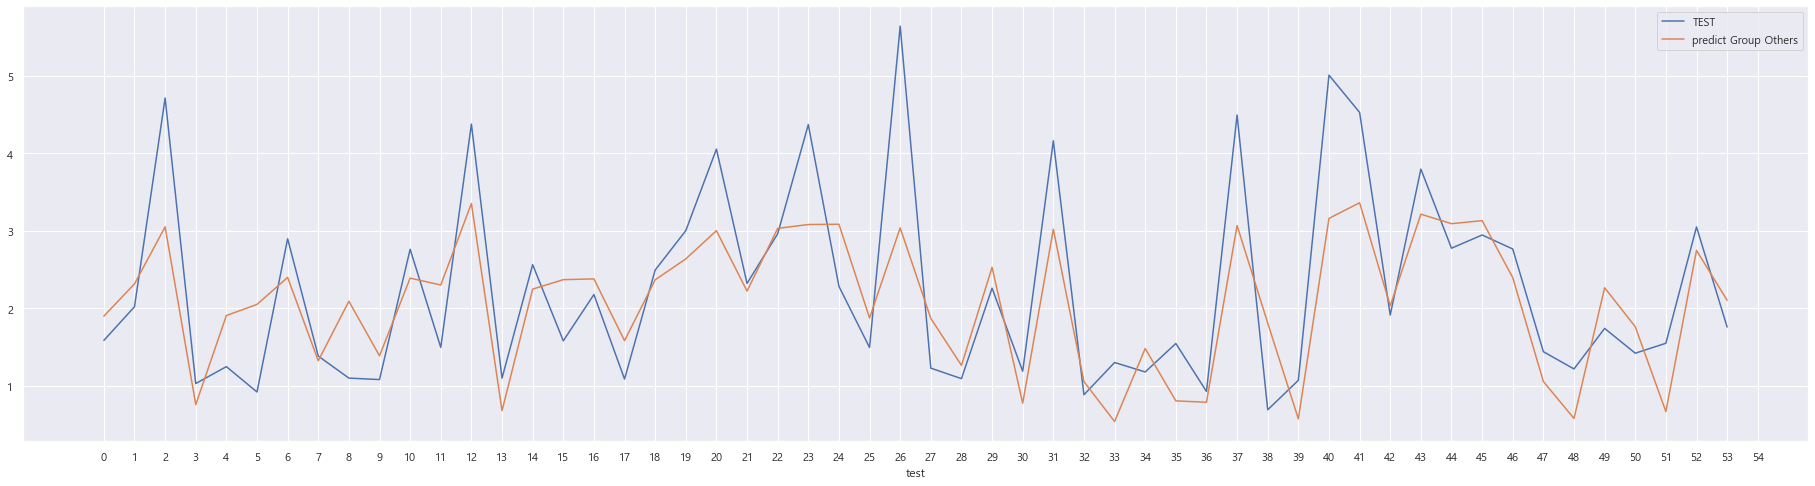

In [42]:
xs = data_a.index.to_list()


fig, axs = plt.subplots(1,1, figsize=(32,8))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(yg_test, label="TEST")
plt.plot(xg_pred, label="predict Group Others")
plt.legend(loc='upper right')
plt.show()

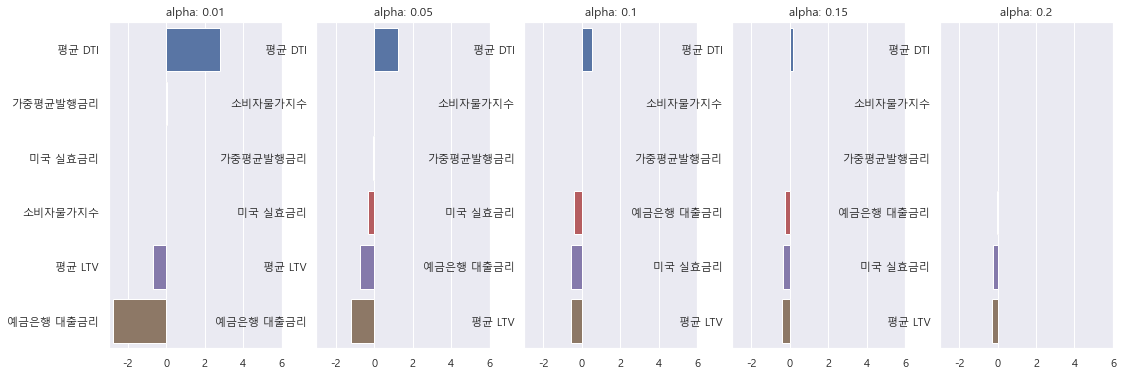

           alpha: 0.01  alpha: 0.05  alpha: 0.1  alpha: 0.15  alpha: 0.2
평균 DTI        2.792371     1.231218    0.531445     0.195663    0.000000
가중평균발행금리      0.017526    -0.053988   -0.000000    -0.000000   -0.000000
미국 실효금리      -0.000000    -0.342922   -0.389596    -0.327151   -0.245365
소비자물가지수      -0.000000     0.000000    0.000000     0.000000    0.000000
평균 LTV       -0.701486    -0.730373   -0.573154    -0.422978   -0.292810
예금은행 대출금리    -2.789327    -1.192874   -0.558274    -0.230501   -0.032567


In [43]:
alphas = [0.01, 0.05, 0.1, 0.15, 0.2]
check_coeff('elastic', feature_data_real_best, target, alphas)

In [44]:
# 최종검증
from sklearn.metrics import mean_squared_error

mse_a = mean_squared_error(ya_test, xa_pred)
rmse_a = mse_a ** 0.5

mse_b = mean_squared_error(yb_test, xb_pred)
rmse_b = mse_b ** 0.5

mse_c = mean_squared_error(yc_test, xc_pred)
rmse_c = mse_c ** 0.5

mse_all = mean_squared_error(yd_test, xd_pred)
rmse_all = mse_all ** 0.5

mse_best = mean_squared_error(ye_test, xe_pred)
rmse_best = mse_best ** 0.5

mse_others = mean_squared_error(yf_test, xf_pred)
rmse_others = mse_others ** 0.5

mse_real_best = mean_squared_error(yg_test, xg_pred)
rmse_real_best = mse_real_best ** 0.5

print(f'금리 요인 RMSE : {rmse_a:.3f}')
print(f'부동산 요인 RMSE : {rmse_b:.3f}')
print(f'거시경제 요인 RMSE : {rmse_c:.3f}')
print(f'전체 요인 RMSE : {rmse_all:.3f}')
print(f'전체 요인 중 가장 영향력 높은 RMSE : {rmse_best:.3f}')
print(f'영향력 높은 요인을 제외한 나머지 RMSE : {rmse_others:.3f}')
print(f'상환율에 영향을 준다고 판단된 요인 RMSE : {rmse_real_best:.3f}')

금리 요인 RMSE : 1.100
부동산 요인 RMSE : 1.064
거시경제 요인 RMSE : 1.230
전체 요인 RMSE : 0.748
전체 요인 중 가장 영향력 높은 RMSE : 0.792
영향력 높은 요인을 제외한 나머지 RMSE : 1.096
상환율에 영향을 준다고 판단된 요인 RMSE : 0.790


In [45]:
# R2 확인 - OLS 분석
import statsmodels.api as sm

lm = sm.OLS(list(target), feature_data_best)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.853
Model:                            OLS   Adj. R-squared (uncentered):              0.851
Method:                 Least Squares   F-statistic:                              305.5
Date:                Thu, 25 Aug 2022   Prob (F-statistic):                    2.63e-86
Time:                        21:31:17   Log-Likelihood:                         -293.31
No. Observations:                 214   AIC:                                      594.6
Df Residuals:                     210   BIC:                                      608.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
평균 LTV         1.3979      0.252      5.538      0.000       0.900       1.896
평균 DTI         5.4041      0.273     19.769      0.000       4.865       5.943
예금은행 대출금리     -3.8481      0.371    -10.362      0.000      -4.580      -3.116
미국 실효금리       -0.6926      0.336     -2.060      0.041      -1.355      -0.030
==============================================================================
Omnibus:                       62.181   Durbin-Watson:                   0.454
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              425.071
Skew:                           0.902   Prob(JB):                     4.98e-93
Kurtosis:                       9.665   Cond. No.                         7.69
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
# 데이터 프레임 만들 때 df.index.name = XX 지정 안 했으면 이름이 없어요
# 이름 넣고 싶으면 별도로 리스트 만들어서 지정해주던가 처음부터 만들어주세요

datas = [feature_data, feature_data_A, feature_data_B, feature_data_C]
names = ['feature_all', 'feature_A', 'feature_B', 'feature_C']
num = range(1,len(datas)+1)

### >> for문에 들어가는 변수의 위치(feature_data는 0)도 VIF출력할 때 번호 붙여서 같이 출력(근데 번호는 1부터 시작하고 싶음)
### 요인들 번호 매기고 VIF 출력
for num, data in zip(num, datas):
        datas[num-1].index.name = names[num-1]
        print(f'번호 {num} - 데이터 이름 {datas[num-1].index.name}')
        find_vif(data)
        print(' ')

번호 1 - 데이터 이름 feature_all
    VIF Factor     features
0   333.161088      소비자물가지수
1   325.060507  주택종합 전세가격지수
2   183.988324  주택종합 매매가격지수
3   140.393226         CD금리
4   108.307462    코스피 월별 종가
5    98.240305    예금은행 대출금리
6    92.952192     가중평균발행금리
7    47.711223       평균 DTI
8    29.260006       평균 LTV
9    18.988968      미국 실효금리
10    9.409641       인플레이션율
11    7.668968  15-64 실업자 수
 
번호 2 - 데이터 이름 feature_A
   VIF Factor   features
0   24.645098  예금은행 대출금리
1   24.338242   가중평균발행금리
2    1.980578    미국 실효금리
 
번호 3 - 데이터 이름 feature_B
   VIF Factor     features
0    2.659064       평균 LTV
1    2.375083       평균 DTI
2    2.321795  주택종합 매매가격지수
 
번호 4 - 데이터 이름 feature_C
   VIF Factor     features
0    7.126936    코스피 월별 종가
1    5.074282       인플레이션율
2    4.078608  15-64 실업자 수
 


In [42]:
#### 그래프 시각화 잘하기